# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.# Your code here.

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).### Exercise 1.1: A baseline MLP

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

## Import Libraries

In [49]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import os
import cv2
from IPython.display import Image
from IPython.display import display

## Data preparation

In the following there is a set of configurations on which depend both the training and the dataset

In [59]:
SPLIT_SIZE = 5000
dataset_str = 'cifar10'  # 'mnist' or 'cifar10'
# Training hyperparameters.
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
LR = 0.001
BATCH_SIZE = 128
CLASSES = 10

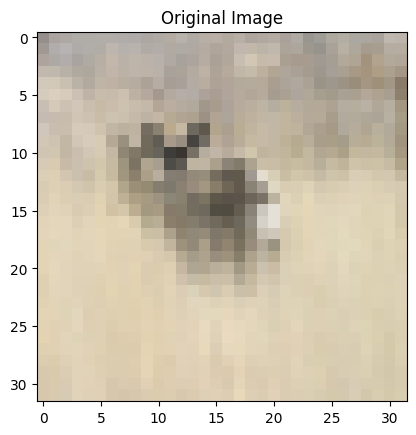

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1428272..1.7098198].


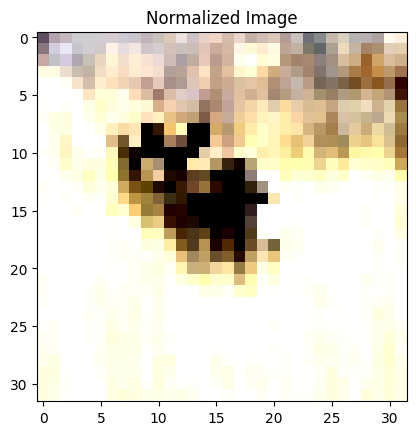

In [60]:
transform = transforms.ToTensor()

if dataset_str == 'mnist':
    # Standard MNIST transform.
    norm = transforms.Normalize((0.1307,), (0.3081,))

    # Load MNIST train and test.
    dataset_str = 'mnist'
    ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
    ds_test = MNIST(root='./data', train=False, download=True, transform=transform)
    img_width = 28
    img_height = 28
    in_channels = 1

    # Split train into train and validation.
    I = np.random.permutation(len(ds_train))
    ds_val = Subset(ds_train, I[:SPLIT_SIZE])
    ds_train = Subset(ds_train, I[SPLIT_SIZE:])

else:
    # Standard CIFAR10 transform.
    norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

    # Load CIFAR10 train and test.
    dataset_str = 'cifar10'
    ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
    ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
    img_width = 32
    img_height = 32
    in_channels = 3

    # Split train into train and validation.
    SPLIT_SIZE = 5000
    I = np.random.permutation(len(ds_train))
    ds_val = Subset(ds_train, I[:SPLIT_SIZE])
    ds_train = Subset(ds_train, I[SPLIT_SIZE:])


# Example Plot
for x, _ in ds_train:
    plt.imshow(x.permute(1, 2, 0))
    plt.title(f'Original Image')
    plt.show()
    break

ds_train.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    norm
])
ds_val.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    norm
])
ds_test.transform = transforms.Compose([
    transforms.ToTensor(),
    norm
])
for x, _ in ds_train:
    plt.imshow(x.permute(1, 2, 0))
    plt.title(f'Normalized Image')
    plt.show()
    break

In [53]:
# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, BATCH_SIZE, shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, BATCH_SIZE, shuffle=True)
dl_test  = torch.utils.data.DataLoader(ds_test, BATCH_SIZE, shuffle=True)

## Utils Functions

The Code has an extensive use of dictionary to make abstraction

In [54]:
def print_dict(d, split):
    for k, v in d.items():
        if k != 'params_grad' and k != 'grad_norm':
            print(f'{split} {k}: {v:.4f}') if split == 'test' else print(f'{split} {k}: {v[-1]:.4f}')

def dict_update(counts_running, counts_batch):
    for k in counts_batch.keys():
        if k not in counts_running:
            counts_running[k] = counts_batch[k]
        else:
            for i in range(len(counts_running[k])):
                counts_running[k][i] += counts_batch[k][i]

def compute_stats(counts):
    stats = {}
    acc = []
    prec = []
    rec = []
    f1 = []
    for i in range(len(counts['tp'])):
        acc.append(counts['tp'][i] / (counts['tp'][i] + counts['fp'][i] + counts['fn'][i]))
        if counts['tp'][i] + counts['fp'][i] == 0:
            prec.append(0)
        else:
            prec.append(counts['tp'][i] / (counts['tp'][i] + counts['fp'][i]))
        rec.append(counts['tp'][i] / (counts['tp'][i] + counts['fn'][i]))
        f1.append(2 * counts['tp'][i] / (2 * counts['tp'][i] + counts['fp'][i] + counts['fn'][i]))
    stats['accuracy'] = torch.mean(torch.tensor(acc)).item()
    stats['precision'] = torch.mean(torch.tensor(prec)).item()
    stats['recall'] = torch.mean(torch.tensor(rec)).item()
    stats['f1'] = torch.mean(torch.tensor(f1)).item()
    return stats

## Trainer Class

In [55]:
class Trainer():
    def __init__(self, model, opt, loss_fn, device, dataset_name):
        self.model = model.to(device)
        self.opt = opt
        self.loss_fn = loss_fn
        self.device = device
        self.dataset_name = dataset_name
        self.writer = SummaryWriter(f'./runs/{dataset_name}/{self.model.name}')

    def compute_grad(self):
        params = [p for p in self.model.parameters() if p.grad is not None and p.requires_grad]
        params_norm = [0] * len(params)
        total_norm = 0
        for i, p in enumerate(params):
            p_grad = p.grad.detach().data.norm(2).item()
            params_norm[i] += p_grad
            total_norm += p_grad**2
        return total_norm**0.5, params_norm

    def compute_loss_counts(self, data, target):
        data, target = data.to(self.device), target.to(self.device)
        output = self.model(data)
        loss = self.loss_fn(output, target)
        pred = torch.argmax(output, dim=1)
        stats = {}
        tp = []
        fn = []
        fp = []
        for i in range(output.shape[1]):
            tp.append(((pred == i).float() * (target == i).float()).sum())
            fn.append(((pred != i).float() * (target == i).float()).sum())
            fp.append(((pred == i).float() * (target != i).float()).sum())
        stats['tp'] = tp
        stats['fp'] = fp
        stats['fn'] = fn
        return loss, stats

    def train_epoch(self, dl_train, grad=False):
        self.model.train()
        loss_epoch = 0
        counts = {}
        grad_norm = 0
        params_grad = []
        for data, target in tqdm(dl_train):
            self.opt.zero_grad()
            loss, counts_batch = self.compute_loss_counts(data, target)
            loss_epoch += loss.item()
            dict_update(counts, counts_batch)
            loss.backward()
            self.opt.step()
            if grad:
                grad_norm_tmp, params_grad_tmp = self.compute_grad()
                if len(params_grad) == 0:
                    params_grad = params_grad_tmp
                else:
                    params_grad = [params_grad[i] + params_grad_tmp[i] for i in range(len(params_grad))]
                grad_norm += grad_norm_tmp

        stats = compute_stats(counts)
        loss_epoch /= len(dl_train)
        dict_epoc = {
            'loss': loss_epoch,
            'stats': stats,
            'grad_norm': grad_norm / len(dl_train),
            'params_grad': [params_grad[i] / len(dl_train) for i in range(len(params_grad))]
        }
        return dict_epoc

    def val_epoch(self, dl_val):
        with torch.no_grad():
            self.model.eval()
            loss_epoch = 0
            counts = {}
            for data, target in tqdm(dl_val):
                loss, counts_batch = self.compute_loss_counts(data, target)
                loss_epoch += loss.item()
                dict_update(counts, counts_batch)
            stats = compute_stats(counts)
            loss_epoch /= len(dl_val)
        return loss_epoch, stats
    
    def plot_loss_stats(self, train_dict, val_dict=None, path_str=None):
        if 'grad_norm' in train_dict.keys():
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
        plt.plot(train_dict['loss'], label='train')
        if val_dict is not None:
            plt.plot(val_dict['x'], val_dict['loss'], label='validation')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()
        if 'grad_norm' in train_dict.keys():
            plt.subplot(1, 2, 2)
            plt.plot(train_dict['grad_norm'])
            plt.xlabel('epochs')
            plt.ylabel('grad_norm')
        plt.title('gradient norm')
        plt.savefig(f'{path_str}/loss.png') if path_str is not None else None

        plt.figure(figsize=(12, 12))
        for i, (k, v) in enumerate(train_dict.items()):
            if k != 'loss' and k != 'grad_norm' and k != 'params_grad':
                plt.subplot(2, 2, i)
                plt.plot(v, label=f'train')
                if val_dict is not None:
                    plt.plot(val_dict['x'], val_dict[k], label=f'validation')
                plt.xlabel('epochs')
                plt.ylabel(k)
                plt.legend()
                plt.title(k)
        plt.savefig(f'{path_str}/stats.png') if path_str is not None else None

        if 'params_grad' in train_dict.keys():
            bins_initial = np.arange(start=0, stop=len(train_dict['params_grad'][0])*3, step=3)
            bins_middle = np.arange(start=1, stop=len(train_dict['params_grad'][0])*3, step=3)
            bins_final = np.arange(start=2, stop=len(train_dict['params_grad'][0])*3, step=3)

            plt.figure(figsize=(20,6))
            plt.bar(bins_initial, train_dict['params_grad'][0], 1, label="initial gradients", log=True)
            plt.bar(bins_middle, train_dict['params_grad'][len(train_dict['params_grad']) // 2], 1, label="middle gradients", log=True)
            plt.bar(bins_final, train_dict['params_grad'][-1], 1, label="final gradients", log=True)
            plt.legend()
            plt.savefig(f'{path_str}/params_grad.png') if path_str is not None else None
        plt.show()
        torch.save(train_dict['grad_norm'], f'{path_str}/grad_norm.pth') if path_str is not None else None
        torch.save(train_dict['params_grad'], f'{path_str}/params_grad.pth') if path_str is not None else None

    def update_writer(self, epoch, dict_values, split):
        for k, v in dict_values.items():
            if k != 'params_grad':
                writer_string = f'{split}/{k}'
                self.writer.add_scalar(writer_string, v[-1], epoch+1)
        self.writer.flush()

    def train(self, epochs, dl_train, dl_val=None, check=5, check_grad=True):
        train_dict = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        if check_grad:
            train_dict['grad_norm'] = []
            train_dict['params_grad'] = []
        val_dict = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []} if dl_val is not None else None
        for epoch in range(epochs):

            #Training epoch
            dict_epoch = self.train_epoch(dl_train, True) if epoch%check_grad == 0 else self.train_epoch(dl_train)
            train_loss = dict_epoch['loss']
            train_stats = dict_epoch['stats']
            train_dict['loss'].append(train_loss)
            for k, v in train_stats.items():
                train_dict[k].append(v)
            if epoch%check_grad == 0:
                train_dict['grad_norm'].append(dict_epoch['grad_norm'])
                train_dict['params_grad'].append(dict_epoch['params_grad'])
            self.update_writer(epoch, train_dict, 'train')
            
            #Validation epoch
            print_check = True if (epoch + 1) % check == 0 or epoch == 0 else False
            if dl_val is not None and print_check:
                val_loss, val_stats = self.val_epoch(dl_val)
                val_dict['loss'].append(val_loss)
                for k, v in val_stats.items():
                    val_dict[k].append(v)
                self.update_writer(epoch, val_dict, 'val')

            #Print pipeline
            if print_check:
                print(f'\nEpoch {epoch+1}/{epochs}')
                print_dict(train_dict, 'train')
                if dl_val is not None:
                    print('')
                    print_dict(val_dict, 'val')
                print('')

        # Save model and plot
        val_dict['x'] = [0] + [i*check-1 for i in range(1, len(val_dict['loss']))] if check != 1 else [i for i in range(len(val_dict['loss']))]
        path_str = f'./models/{self.dataset_name}/{self.model.name}'
        if not os.path.exists(path_str):
            os.makedirs(path_str)
        torch.save(self.model.state_dict(), f'{path_str}/model_{epochs}.pth')
        self.plot_loss_stats(train_dict, val_dict, path_str)
        
    def test(self, test_loader):
        with torch.no_grad():
            self.model.eval()
            counts = {}
            test_loss = 0
            for data, target in tqdm(test_loader):
                loss, counts_batch = self.compute_loss_counts(data, target)
                dict_update(counts, counts_batch)
                test_loss += loss.item()
            test_loss /= len(test_loader)
            test_stats = compute_stats(counts)
        print_dict(test_stats, 'test')

In [56]:
class Linear_layer(nn.Module):
    def __init__(self, dim_in, dim_out, activation=nn.ReLU()):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out)
        self.activation = activation

    def forward(self, x):
        logits = self.linear(x)
        return self.activation(logits)

class MLP(nn.Module):
    def __init__(self, input_shape, layer_sizes, classes):
        super().__init__()
        sep = '_'
        layers_str = sep.join([str(i) for i in layer_sizes])
        self.name = 'MLP_classic_' + layers_str
        input_flat = np.prod(input_shape)
        layer_sizes = [input_flat] + layer_sizes + [classes]

        self.layers = nn.Sequential(
            *[Linear_layer(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)]
        )
    
    def forward(self, x):
        return self.layers(x.flatten(1))

  0%|          | 0/430 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 40.53it/s]



Epoch 1/10
train loss: 1.9821
train accuracy: 0.0464
train precision: 0.0473
train recall: 0.1916
train f1: 0.0732

val loss: 1.9109
val accuracy: 0.0662
val precision: 0.0680
val recall: 0.1938
val f1: 0.0916



100%|██████████| 40/40 [00:01<00:00, 39.77it/s]



Epoch 2/10
train loss: 1.9128
train accuracy: 0.0753
train precision: 0.0774
train recall: 0.1946
train f1: 0.0985

val loss: 1.8783
val accuracy: 0.0802
val precision: 0.0826
val recall: 0.1951
val f1: 0.1020



100%|██████████| 40/40 [00:00<00:00, 40.98it/s]



Epoch 3/10
train loss: 1.9022
train accuracy: 0.0836
train precision: 0.1361
train recall: 0.1952
train f1: 0.1042

val loss: 1.8726
val accuracy: 0.0855
val precision: 0.0888
val recall: 0.1944
val f1: 0.1054



100%|██████████| 40/40 [00:00<00:00, 41.04it/s]



Epoch 4/10
train loss: 1.8959
train accuracy: 0.0874
train precision: 0.1010
train recall: 0.1954
train f1: 0.1066

val loss: 1.8765
val accuracy: 0.0875
val precision: 0.0900
val recall: 0.1957
val f1: 0.1067



100%|██████████| 40/40 [00:00<00:00, 40.64it/s]



Epoch 5/10
train loss: 1.8932
train accuracy: 0.0904
train precision: 0.2179
train recall: 0.1956
train f1: 0.1084

val loss: 1.8817
val accuracy: 0.0892
val precision: 0.0914
val recall: 0.1964
val f1: 0.1078



100%|██████████| 40/40 [00:00<00:00, 41.01it/s]



Epoch 6/10
train loss: 1.7317
train accuracy: 0.1453
train precision: 0.1646
train recall: 0.2884
train f1: 0.1815

val loss: 1.7012
val accuracy: 0.1540
val precision: 0.1589
val recall: 0.2903
val f1: 0.1884



100%|██████████| 40/40 [00:00<00:00, 40.88it/s]



Epoch 7/10
train loss: 1.7006
train accuracy: 0.1614
train precision: 0.1858
train recall: 0.2921
train f1: 0.1933

val loss: 1.7049
val accuracy: 0.1623
val precision: 0.1679
val recall: 0.2910
val f1: 0.1936



100%|██████████| 40/40 [00:00<00:00, 40.85it/s]



Epoch 8/10
train loss: 1.6936
train accuracy: 0.1679
train precision: 0.1974
train recall: 0.2926
train f1: 0.1974

val loss: 1.7034
val accuracy: 0.1618
val precision: 0.1670
val recall: 0.2919
val f1: 0.1933



100%|██████████| 40/40 [00:00<00:00, 40.12it/s]



Epoch 9/10
train loss: 1.6890
train accuracy: 0.1714
train precision: 0.2007
train recall: 0.2931
train f1: 0.1995

val loss: 1.6928
val accuracy: 0.1723
val precision: 0.1785
val recall: 0.2908
val f1: 0.2000



100%|██████████| 40/40 [00:01<00:00, 39.59it/s]



Epoch 10/10
train loss: 1.6842
train accuracy: 0.1733
train precision: 0.2108
train recall: 0.2934
train f1: 0.2007

val loss: 1.6910
val accuracy: 0.1653
val precision: 0.1688
val recall: 0.2935
val f1: 0.1959



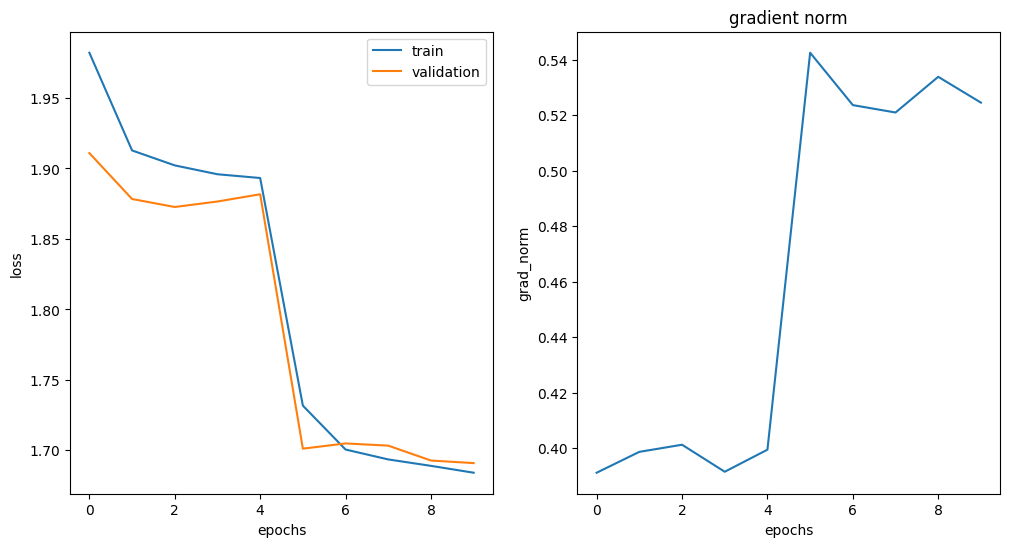

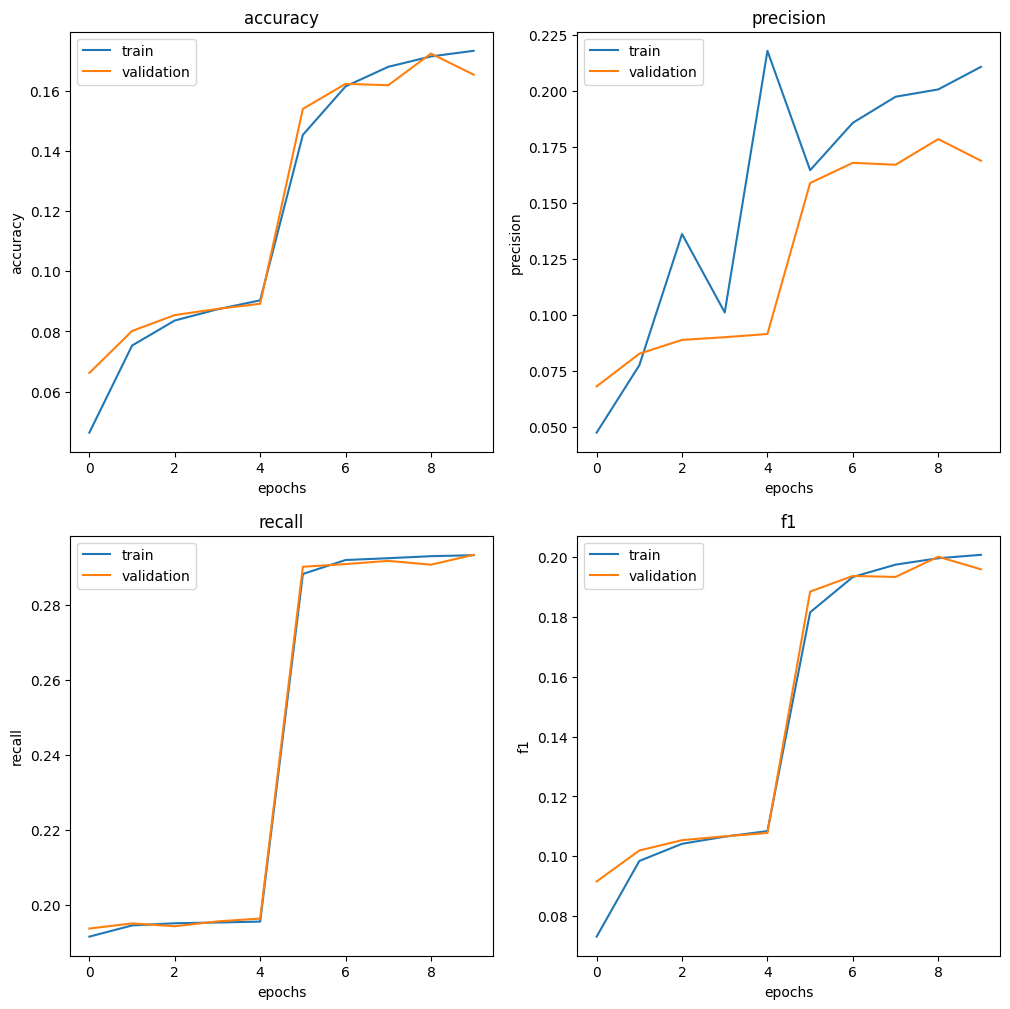

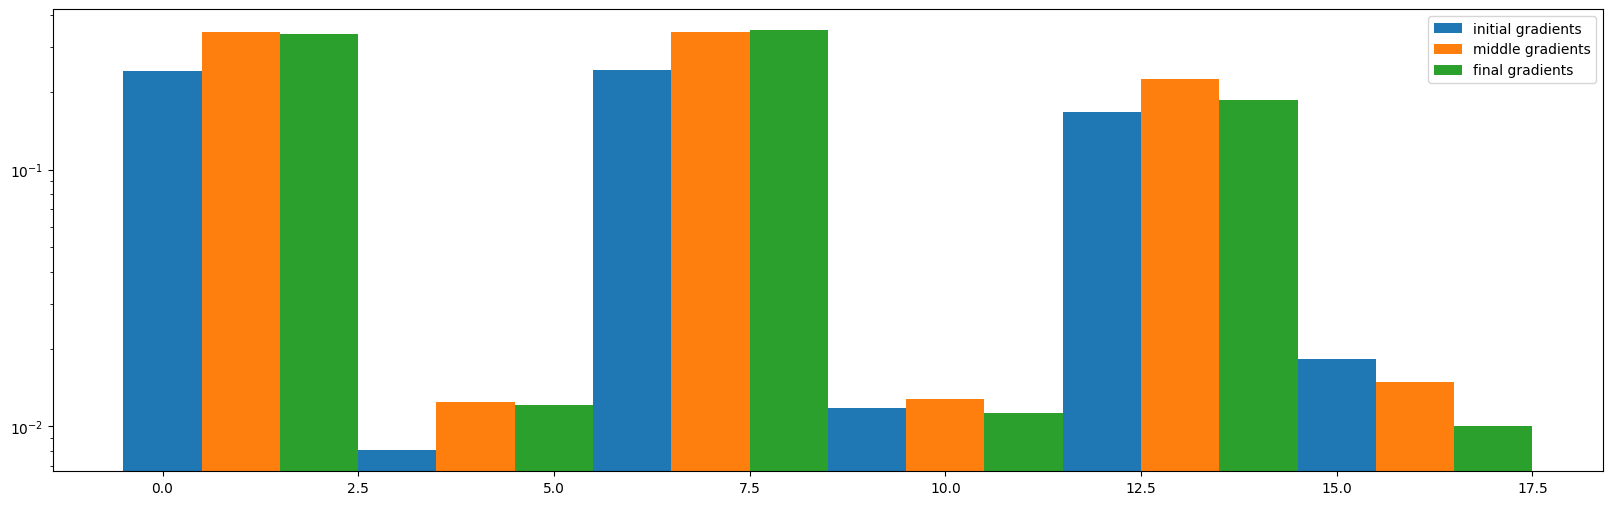

100%|██████████| 79/79 [00:02<00:00, 39.34it/s]

test accuracy: 0.1669
test precision: 0.1702
test recall: 0.2939
test f1: 0.1967


In [58]:
# Architecture hyperparameters.
net_width = 16
net_depth = 2

# Instantiate model and optimizer.
model_mlp = MLP(x.shape, [net_width]*net_depth, CLASSES).to(DEVICE)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=LR)
trainer = Trainer(model_mlp, opt, F.cross_entropy, DEVICE, dataset_str)

# Training loop.
trainer.train(10, dl_train, dl_val, check=1)
# Test loop.
trainer.test(dl_test)

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, activation=nn.ReLU()):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = activation

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ConvBlock(nn.Module):
    def __init__(self, channels, block_dim, residual):
        super().__init__()
        self.residual = residual
        self.block = nn.ModuleList([ConvLayer(channels, channels) for _ in range(block_dim)])

    def forward(self, x):
        logits = x
        for i, m in enumerate(self.block):
            logits = m(logits)
            if self.residual and i % 2 == 0 and i != 0:
                logits = logits + x
                x = logits
        return logits

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, block_dim, residual):
        super().__init__()
        self.pool_layer = ConvLayer(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.conv_block = ConvBlock(out_channels, block_dim, residual)

    def forward(self, x):
        logits = self.pool_layer(x)
        logits = self.conv_block(logits)
        return logits

class CNN(nn.Module):
    def __init__(self, block_ch, block_dim, classes, residual=False):
        super().__init__()
        res_str = 'res' if residual else 'classic'
        self.name = f'CNN_{res_str}_nb={block_dim}'
        self.blocks = nn.Sequential(*[ResBlock(block_ch[i], block_ch[i+1], block_dim, residual) for i in range(len(block_ch)-1)])
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                    nn.Flatten(),
                                    nn.Linear(block_ch[-1], classes))

    def forward(self, x):
        logits = self.blocks(x)
        return self.head(logits)

100%|██████████| 40/40 [00:02<00:00, 15.35it/s]



Epoch 1/50
train loss: 2.2940
train accuracy: 0.0523
train precision: 0.1300
train recall: 0.1111
train f1: 0.0984

val loss: 2.9006
val accuracy: 0.0222
val precision: 0.0396
val recall: 0.1111
val f1: 0.0405



100%|██████████| 40/40 [00:02<00:00, 15.45it/s]



Epoch 2/50
train loss: 2.2632
train accuracy: 0.0622
train precision: 0.1291
train recall: 0.1240
train f1: 0.1160

val loss: 2.3013
val accuracy: 0.0125
val precision: 0.0254
val recall: 0.1015
val f1: 0.0231



100%|██████████| 40/40 [00:02<00:00, 15.31it/s]



Epoch 3/50
train loss: 2.2688
train accuracy: 0.0601
train precision: 0.1382
train recall: 0.1281
train f1: 0.1124

val loss: 2.2193
val accuracy: 0.0465
val precision: 0.0614
val recall: 0.1693
val f1: 0.0805



100%|██████████| 40/40 [00:02<00:00, 15.11it/s]



Epoch 4/50
train loss: 2.2832
train accuracy: 0.0548
train precision: 0.1256
train recall: 0.1226
train f1: 0.1028

val loss: 2.2873
val accuracy: 0.0217
val precision: 0.0383
val recall: 0.1056
val f1: 0.0391



100%|██████████| 40/40 [00:02<00:00, 15.36it/s]



Epoch 5/50
train loss: 2.2415
train accuracy: 0.0662
train precision: 0.1503
train recall: 0.1370
train f1: 0.1227

val loss: 2.3079
val accuracy: 0.0135
val precision: 0.1278
val recall: 0.1026
val f1: 0.0250



100%|██████████| 40/40 [00:02<00:00, 15.58it/s]



Epoch 6/50
train loss: 2.2890
train accuracy: 0.0471
train precision: 0.1288
train recall: 0.1094
train f1: 0.0887

val loss: 2.6409
val accuracy: 0.0105
val precision: 0.0105
val recall: 0.1000
val f1: 0.0190



100%|██████████| 40/40 [00:02<00:00, 15.07it/s]



Epoch 7/50
train loss: 2.2830
train accuracy: 0.0511
train precision: 0.1244
train recall: 0.1117
train f1: 0.0960

val loss: 2.5713
val accuracy: 0.0186
val precision: 0.0437
val recall: 0.1019
val f1: 0.0340



100%|██████████| 40/40 [00:02<00:00, 15.34it/s]



Epoch 8/50
train loss: 2.2689
train accuracy: 0.0550
train precision: 0.1246
train recall: 0.1233
train f1: 0.1027

val loss: 2.2849
val accuracy: 0.0252
val precision: 0.0350
val recall: 0.1232
val f1: 0.0447



100%|██████████| 40/40 [00:02<00:00, 16.81it/s]



Epoch 9/50
train loss: 2.0805
train accuracy: 0.0940
train precision: 0.1838
train recall: 0.1880
train f1: 0.1690

val loss: 18.6772
val accuracy: 0.0251
val precision: 0.0920
val recall: 0.1163
val f1: 0.0453



100%|██████████| 40/40 [00:02<00:00, 16.80it/s]



Epoch 10/50
train loss: 1.9034
train accuracy: 0.1218
train precision: 0.2431
train recall: 0.2391
train f1: 0.2119

val loss: 5.6873
val accuracy: 0.0291
val precision: 0.0916
val recall: 0.1133
val f1: 0.0512



100%|██████████| 40/40 [00:02<00:00, 16.84it/s]



Epoch 11/50
train loss: 1.8528
train accuracy: 0.1310
train precision: 0.2593
train recall: 0.2592
train f1: 0.2243

val loss: 10.2462
val accuracy: 0.0205
val precision: 0.0879
val recall: 0.1112
val f1: 0.0373



100%|██████████| 40/40 [00:02<00:00, 15.90it/s]



Epoch 12/50
train loss: 1.9341
train accuracy: 0.1213
train precision: 0.2274
train recall: 0.2393
train f1: 0.2094

val loss: 2.3614
val accuracy: 0.0184
val precision: 0.0485
val recall: 0.1026
val f1: 0.0343



100%|██████████| 40/40 [00:02<00:00, 16.66it/s]



Epoch 13/50
train loss: 2.3027
train accuracy: 0.0394
train precision: 0.1102
train recall: 0.1026
train f1: 0.0745

val loss: 2.2989
val accuracy: 0.0163
val precision: 0.0265
val recall: 0.1064
val f1: 0.0301



100%|██████████| 40/40 [00:02<00:00, 16.68it/s]



Epoch 14/50
train loss: 2.3018
train accuracy: 0.0452
train precision: 0.1161
train recall: 0.1016
train f1: 0.0854

val loss: 2.3051
val accuracy: 0.0141
val precision: 0.0330
val recall: 0.1018
val f1: 0.0261



100%|██████████| 40/40 [00:02<00:00, 16.70it/s]



Epoch 15/50
train loss: 2.3008
train accuracy: 0.0381
train precision: 0.0935
train recall: 0.1018
train f1: 0.0718

val loss: 2.3137
val accuracy: 0.0222
val precision: 0.0382
val recall: 0.1114
val f1: 0.0411



100%|██████████| 40/40 [00:02<00:00, 16.85it/s]



Epoch 16/50
train loss: 2.2935
train accuracy: 0.0425
train precision: 0.1229
train recall: 0.1123
train f1: 0.0800

val loss: 2.2896
val accuracy: 0.0244
val precision: 0.0417
val recall: 0.1170
val f1: 0.0450



100%|██████████| 40/40 [00:02<00:00, 16.83it/s]



Epoch 17/50
train loss: 2.2922
train accuracy: 0.0401
train precision: 0.1182
train recall: 0.1164
train f1: 0.0753

val loss: 2.2978
val accuracy: 0.0211
val precision: 0.0882
val recall: 0.1101
val f1: 0.0394



100%|██████████| 40/40 [00:02<00:00, 16.99it/s]



Epoch 18/50
train loss: 2.2969
train accuracy: 0.0431
train precision: 0.0970
train recall: 0.1080
train f1: 0.0812

val loss: 2.2954
val accuracy: 0.0203
val precision: 0.0514
val recall: 0.1097
val f1: 0.0377



100%|██████████| 40/40 [00:02<00:00, 17.08it/s]



Epoch 19/50
train loss: 2.2931
train accuracy: 0.0381
train precision: 0.1104
train recall: 0.1132
train f1: 0.0707

val loss: 2.2958
val accuracy: 0.0210
val precision: 0.0409
val recall: 0.1082
val f1: 0.0390



100%|██████████| 40/40 [00:02<00:00, 16.88it/s]



Epoch 20/50
train loss: 2.2921
train accuracy: 0.0444
train precision: 0.1404
train recall: 0.1133
train f1: 0.0836

val loss: 2.2827
val accuracy: 0.0271
val precision: 0.0777
val recall: 0.1225
val f1: 0.0494



100%|██████████| 40/40 [00:02<00:00, 16.89it/s]



Epoch 21/50
train loss: 2.2860
train accuracy: 0.0421
train precision: 0.1151
train recall: 0.1207
train f1: 0.0782

val loss: 2.2824
val accuracy: 0.0334
val precision: 0.0889
val recall: 0.1326
val f1: 0.0606



100%|██████████| 40/40 [00:02<00:00, 15.41it/s]



Epoch 22/50
train loss: 2.2729
train accuracy: 0.0421
train precision: 0.0960
train recall: 0.1233
train f1: 0.0775

val loss: 2.2763
val accuracy: 0.0229
val precision: 0.0605
val recall: 0.1152
val f1: 0.0409



100%|██████████| 40/40 [00:02<00:00, 15.39it/s]



Epoch 23/50
train loss: 2.2462
train accuracy: 0.0575
train precision: 0.1449
train recall: 0.1284
train f1: 0.1058

val loss: 3.3408
val accuracy: 0.0096
val precision: 0.0096
val recall: 0.1000
val f1: 0.0176



100%|██████████| 40/40 [00:02<00:00, 15.51it/s]



Epoch 24/50
train loss: 2.0866
train accuracy: 0.0968
train precision: 0.1877
train recall: 0.1966
train f1: 0.1718

val loss: 2.3094
val accuracy: 0.0826
val precision: 0.1182
val recall: 0.1980
val f1: 0.1434



100%|██████████| 40/40 [00:02<00:00, 15.48it/s]



Epoch 25/50
train loss: 1.9757
train accuracy: 0.1114
train precision: 0.2063
train recall: 0.2158
train f1: 0.1966

val loss: 2.4633
val accuracy: 0.0096
val precision: 0.0096
val recall: 0.1000
val f1: 0.0176



100%|██████████| 40/40 [00:02<00:00, 15.15it/s]



Epoch 26/50
train loss: 1.9077
train accuracy: 0.1248
train precision: 0.2407
train recall: 0.2409
train f1: 0.2170

val loss: 2.8227
val accuracy: 0.0242
val precision: 0.0671
val recall: 0.1064
val f1: 0.0430



100%|██████████| 40/40 [00:02<00:00, 14.98it/s]



Epoch 27/50
train loss: 1.8918
train accuracy: 0.1242
train precision: 0.2491
train recall: 0.2411
train f1: 0.2160

val loss: 5.9341
val accuracy: 0.0196
val precision: 0.0332
val recall: 0.1039
val f1: 0.0356



100%|██████████| 40/40 [00:02<00:00, 15.43it/s]



Epoch 28/50
train loss: 1.9249
train accuracy: 0.1186
train precision: 0.2418
train recall: 0.2348
train f1: 0.2063

val loss: 4.0438
val accuracy: 0.0231
val precision: 0.0347
val recall: 0.1049
val f1: 0.0412



100%|██████████| 40/40 [00:02<00:00, 15.24it/s]



Epoch 29/50
train loss: 1.9971
train accuracy: 0.1069
train precision: 0.2063
train recall: 0.2141
train f1: 0.1887

val loss: 2.9326
val accuracy: 0.0183
val precision: 0.1061
val recall: 0.1029
val f1: 0.0338



100%|██████████| 40/40 [00:02<00:00, 15.64it/s]



Epoch 30/50
train loss: 2.0985
train accuracy: 0.0892
train precision: 0.1884
train recall: 0.1753
train f1: 0.1610

val loss: 2.2961
val accuracy: 0.0214
val precision: 0.0599
val recall: 0.1073
val f1: 0.0390



100%|██████████| 40/40 [00:02<00:00, 15.32it/s]



Epoch 31/50
train loss: 2.2594
train accuracy: 0.0477
train precision: 0.1178
train recall: 0.1290
train f1: 0.0872

val loss: 2.4210
val accuracy: 0.0244
val precision: 0.0326
val recall: 0.1124
val f1: 0.0432



100%|██████████| 40/40 [00:02<00:00, 15.02it/s]



Epoch 32/50
train loss: 2.2296
train accuracy: 0.0623
train precision: 0.1545
train recall: 0.1410
train f1: 0.1147

val loss: 2.6208
val accuracy: 0.0174
val precision: 0.0378
val recall: 0.1019
val f1: 0.0319



100%|██████████| 40/40 [00:02<00:00, 15.25it/s]



Epoch 33/50
train loss: 2.2696
train accuracy: 0.0466
train precision: 0.1215
train recall: 0.1235
train f1: 0.0864

val loss: 2.3145
val accuracy: 0.0333
val precision: 0.0534
val recall: 0.1181
val f1: 0.0596



100%|██████████| 40/40 [00:02<00:00, 15.16it/s]



Epoch 34/50
train loss: 2.2303
train accuracy: 0.0539
train precision: 0.1544
train recall: 0.1582
train f1: 0.0962

val loss: 2.2152
val accuracy: 0.0435
val precision: 0.0607
val recall: 0.1546
val f1: 0.0759



100%|██████████| 40/40 [00:02<00:00, 15.43it/s]



Epoch 35/50
train loss: 2.2092
train accuracy: 0.0626
train precision: 0.1207
train recall: 0.1756
train f1: 0.1110

val loss: 2.3763
val accuracy: 0.0372
val precision: 0.0729
val recall: 0.1312
val f1: 0.0669



100%|██████████| 40/40 [00:02<00:00, 15.51it/s]



Epoch 36/50
train loss: 2.2084
train accuracy: 0.0681
train precision: 0.1547
train recall: 0.1761
train f1: 0.1215

val loss: 2.2577
val accuracy: 0.0495
val precision: 0.1684
val recall: 0.1536
val f1: 0.0875



100%|██████████| 40/40 [00:02<00:00, 15.29it/s]



Epoch 37/50
train loss: 2.1965
train accuracy: 0.0724
train precision: 0.1811
train recall: 0.1802
train f1: 0.1288

val loss: 2.4503
val accuracy: 0.0112
val precision: 0.0278
val recall: 0.0997
val f1: 0.0205



100%|██████████| 40/40 [00:02<00:00, 15.03it/s]



Epoch 38/50
train loss: 2.1881
train accuracy: 0.0658
train precision: 0.1322
train recall: 0.1775
train f1: 0.1174

val loss: 2.2337
val accuracy: 0.0448
val precision: 0.0528
val recall: 0.1652
val f1: 0.0777



100%|██████████| 40/40 [00:02<00:00, 15.35it/s]



Epoch 39/50
train loss: 2.1651
train accuracy: 0.0759
train precision: 0.1389
train recall: 0.1893
train f1: 0.1339

val loss: 2.2879
val accuracy: 0.0172
val precision: 0.0885
val recall: 0.1046
val f1: 0.0323



100%|██████████| 40/40 [00:02<00:00, 15.27it/s]



Epoch 40/50
train loss: 2.1625
train accuracy: 0.0823
train precision: 0.1605
train recall: 0.1926
train f1: 0.1455

val loss: 2.5336
val accuracy: 0.0435
val precision: 0.1088
val recall: 0.1200
val f1: 0.0788



100%|██████████| 40/40 [00:02<00:00, 15.42it/s]



Epoch 41/50
train loss: 2.2277
train accuracy: 0.0640
train precision: 0.1509
train recall: 0.1621
train f1: 0.1157

val loss: 2.2612
val accuracy: 0.0409
val precision: 0.0841
val recall: 0.1439
val f1: 0.0731



100%|██████████| 40/40 [00:02<00:00, 15.21it/s]



Epoch 42/50
train loss: 2.2291
train accuracy: 0.0571
train precision: 0.1191
train recall: 0.1603
train f1: 0.1032

val loss: 2.2934
val accuracy: 0.0295
val precision: 0.0386
val recall: 0.1297
val f1: 0.0532



100%|██████████| 40/40 [00:02<00:00, 15.25it/s]



Epoch 43/50
train loss: 2.2197
train accuracy: 0.0641
train precision: 0.1350
train recall: 0.1675
train f1: 0.1157

val loss: 2.3394
val accuracy: 0.0252
val precision: 0.0267
val recall: 0.1353
val f1: 0.0447



100%|██████████| 40/40 [00:02<00:00, 15.40it/s]



Epoch 44/50
train loss: 2.1753
train accuracy: 0.0769
train precision: 0.1565
train recall: 0.1853
train f1: 0.1364

val loss: 2.4208
val accuracy: 0.0118
val precision: 0.0253
val recall: 0.0627
val f1: 0.0224



100%|██████████| 40/40 [00:02<00:00, 15.33it/s]



Epoch 45/50
train loss: 2.2125
train accuracy: 0.0679
train precision: 0.1416
train recall: 0.1477
train f1: 0.1239

val loss: 2.2704
val accuracy: 0.0394
val precision: 0.1032
val recall: 0.1265
val f1: 0.0715



100%|██████████| 40/40 [00:02<00:00, 15.31it/s]



Epoch 46/50
train loss: 2.2415
train accuracy: 0.0369
train precision: 0.1115
train recall: 0.1390
train f1: 0.0666

val loss: 2.2420
val accuracy: 0.0223
val precision: 0.0260
val recall: 0.1260
val f1: 0.0401



100%|██████████| 40/40 [00:02<00:00, 15.68it/s]



Epoch 47/50
train loss: 2.2138
train accuracy: 0.0636
train precision: 0.1277
train recall: 0.1599
train f1: 0.1149

val loss: 2.2432
val accuracy: 0.0275
val precision: 0.0328
val recall: 0.1258
val f1: 0.0477



100%|██████████| 40/40 [00:02<00:00, 15.24it/s]



Epoch 48/50
train loss: 2.1731
train accuracy: 0.0723
train precision: 0.1617
train recall: 0.1696
train f1: 0.1303

val loss: 2.8783
val accuracy: 0.0432
val precision: 0.0934
val recall: 0.1446
val f1: 0.0767



100%|██████████| 40/40 [00:02<00:00, 15.63it/s]



Epoch 49/50
train loss: 2.0870
train accuracy: 0.0926
train precision: 0.1770
train recall: 0.1951
train f1: 0.1648

val loss: 2.1689
val accuracy: 0.0631
val precision: 0.1822
val recall: 0.1701
val f1: 0.1128



100%|██████████| 40/40 [00:02<00:00, 15.16it/s]



Epoch 50/50
train loss: 2.0811
train accuracy: 0.0878
train precision: 0.1702
train recall: 0.1969
train f1: 0.1551

val loss: 2.4958
val accuracy: 0.0194
val precision: 0.0622
val recall: 0.1052
val f1: 0.0359



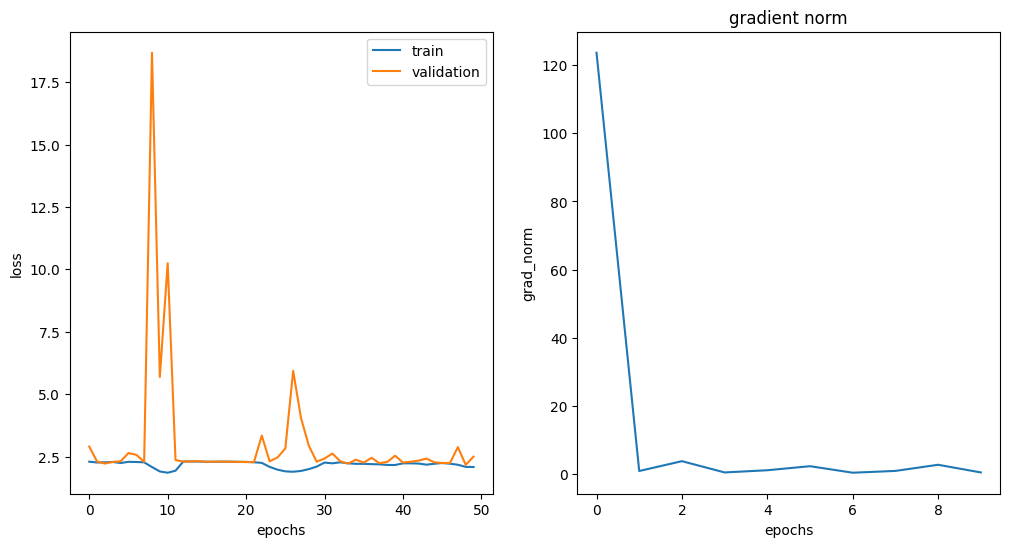

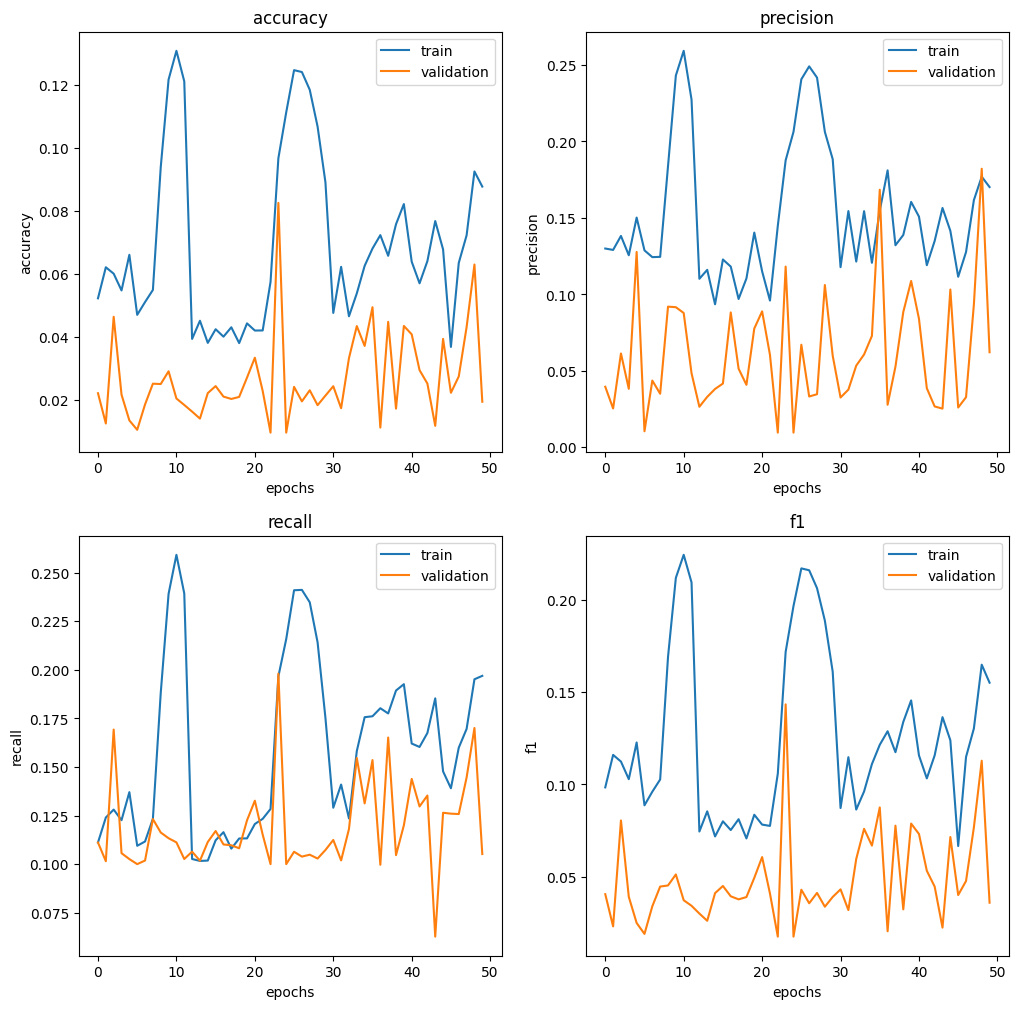

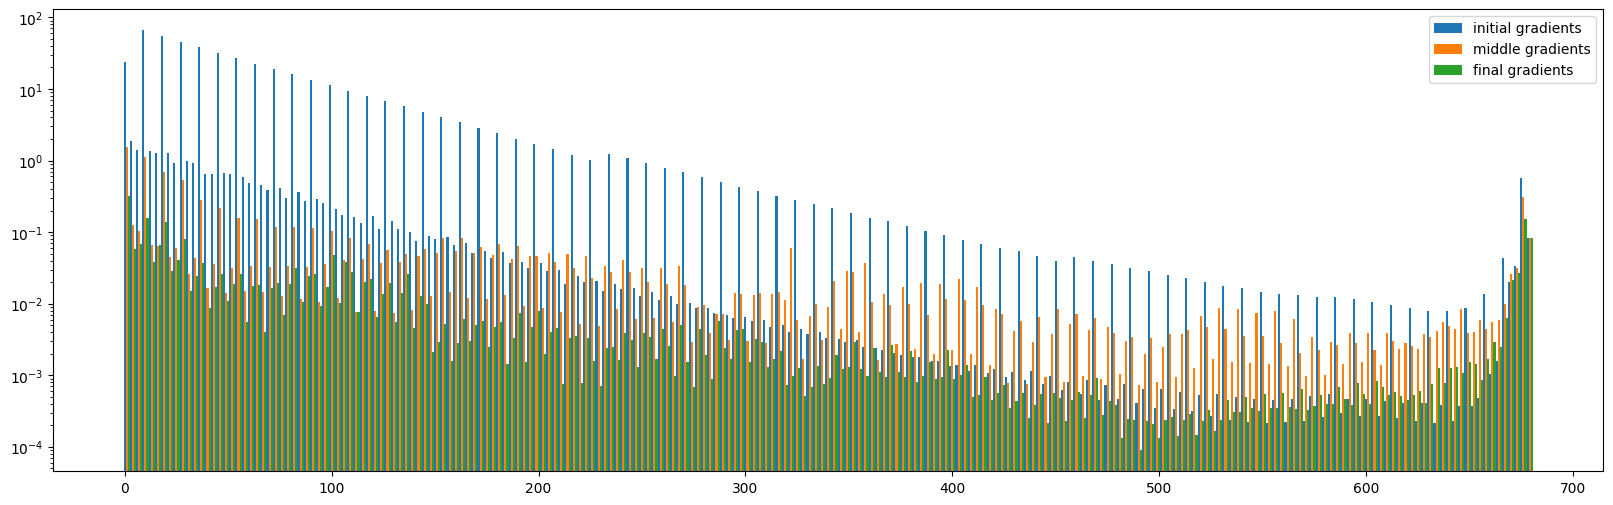

100%|██████████| 79/79 [00:05<00:00, 15.18it/s]


test accuracy: 0.0201
test precision: 0.0701
test recall: 0.1047
test f1: 0.0373


In [ ]:
# Architecture hyperparameters.
channels = [in_channels, 64, 128, 256]
block_dim = 24
residual = False

# Instantiate model and optimizer.
model_cnn = CNN(channels, block_dim, CLASSES, residual).to(DEVICE)
opt = torch.optim.Adam(params=model_cnn.parameters(), lr=LR)
trainer = Trainer(model_cnn, opt, F.cross_entropy, DEVICE, dataset_str)

# Training loop.
trainer.train(EPOCHS, dl_train, dl_val, check=1, check_grad=5)

# Test loop.
trainer.test(dl_test)

# Exercise 2.1

Let's see the gradients behavior in four different situations small, medium, large and huge models, each one with and without residual connections

In [ ]:
def display_grads(nb, dataset_str='cifar10'):
    base_path = f'./models/{dataset_str}'
    classic_str = f'CNN_classic_nb={nb}/params_grad.pth'
    res_str = f'CNN_res_nb={nb}/params_grad.pth'
    classic_path = f'{base_path}/{classic_str}'
    res_path = f'{base_path}/{res_str}'
    classic = torch.load(classic_path)

    bins_initial = np.arange(start=0, stop=len(classic[0])*3, step=3)
    bins_middle = np.arange(start=1, stop=len(classic[0])*3, step=3)
    bins_final = np.arange(start=2, stop=len(classic[0])*3, step=3)

    plt.figure(figsize=(20,6))
    plt.bar(bins_initial, classic[0], 1, label="initial gradients", log=True)
    plt.bar(bins_middle, classic[len(classic) // 2], 1, label="middle gradients", log=True)
    plt.bar(bins_final, classic[-1], 1, label="final gradients", log=True)
    if nb >= 12:
        plt.ylim([1e-6, 1])
    else:
        plt.ylim([1e-3, 1])
    plt.title(f'Gradients for {dataset_str} CNN classic {nb} blocks')
    plt.legend()

    res = torch.load(res_path)

    plt.figure(figsize=(20,6))
    plt.bar(bins_initial, res[0], 1, label="initial gradients", log=True)
    plt.bar(bins_middle, res[len(res) // 2], 1, label="middle gradients", log=True)
    plt.bar(bins_final, res[-1], 1, label="final gradients", log=True)
    if nb >= 12:
        plt.ylim([1e-6, 1])
    else:
        plt.ylim([1e-3, 1])

    plt.title(f'Gradients for {dataset_str} CNN res {nb} blocks')
    plt.legend()
    plt.show()

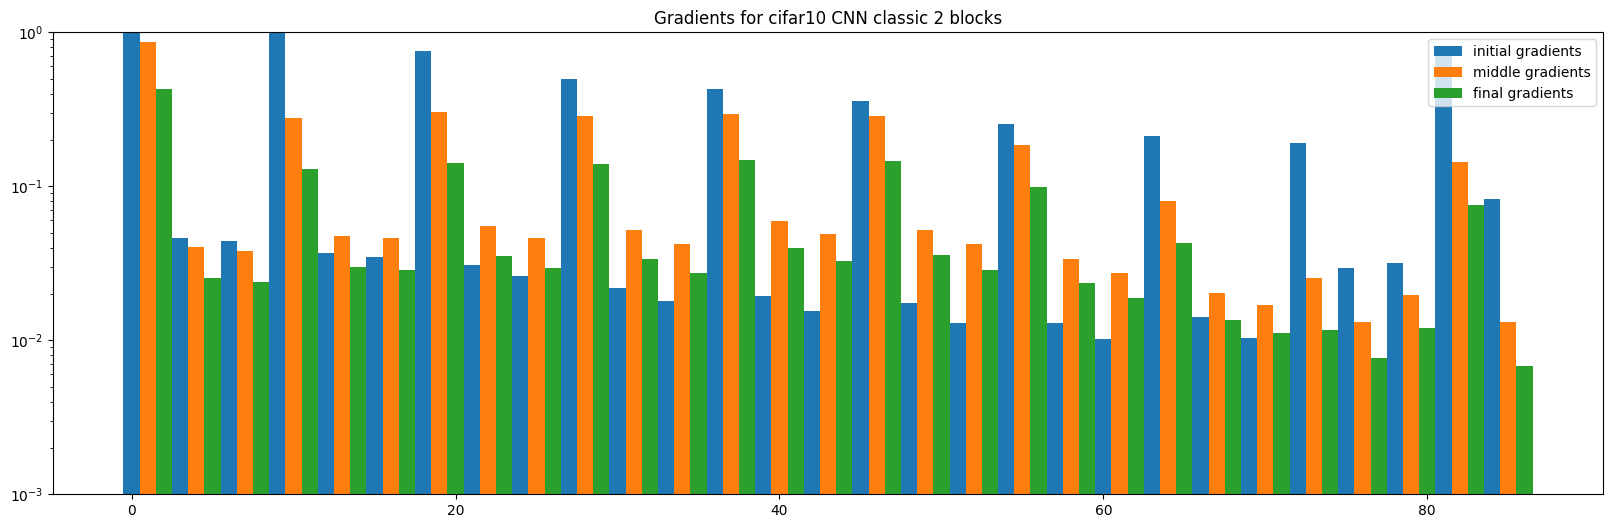

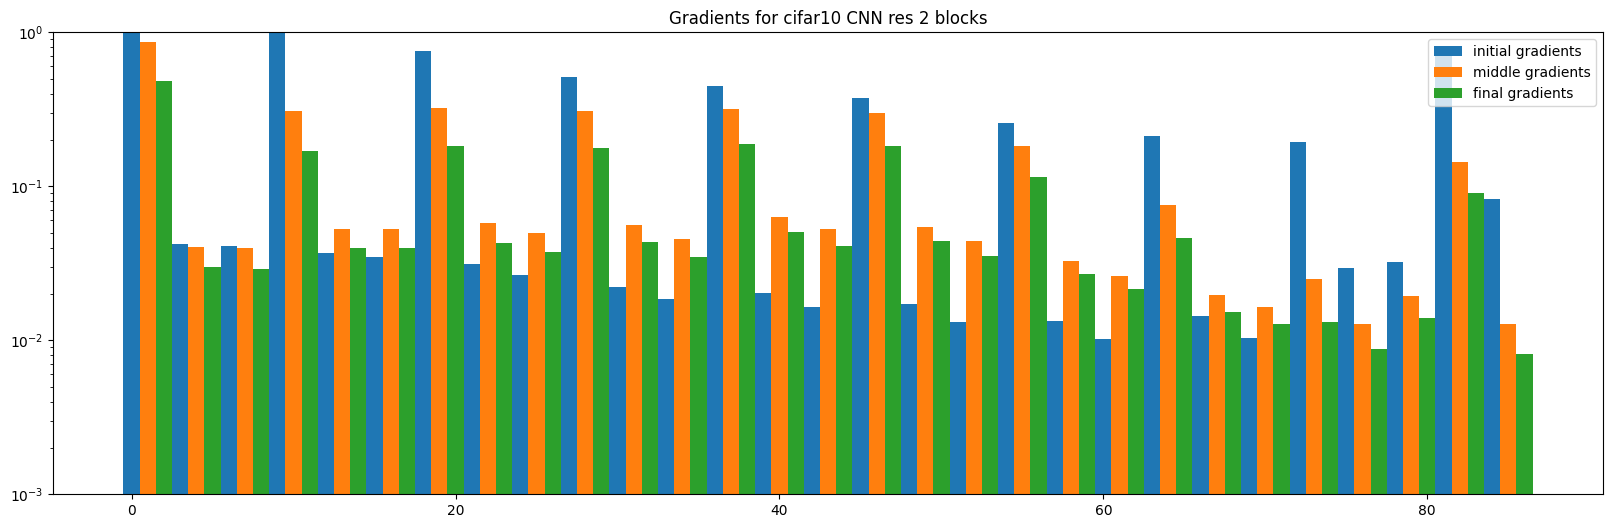

In [69]:
# Small models
display_grads(2)

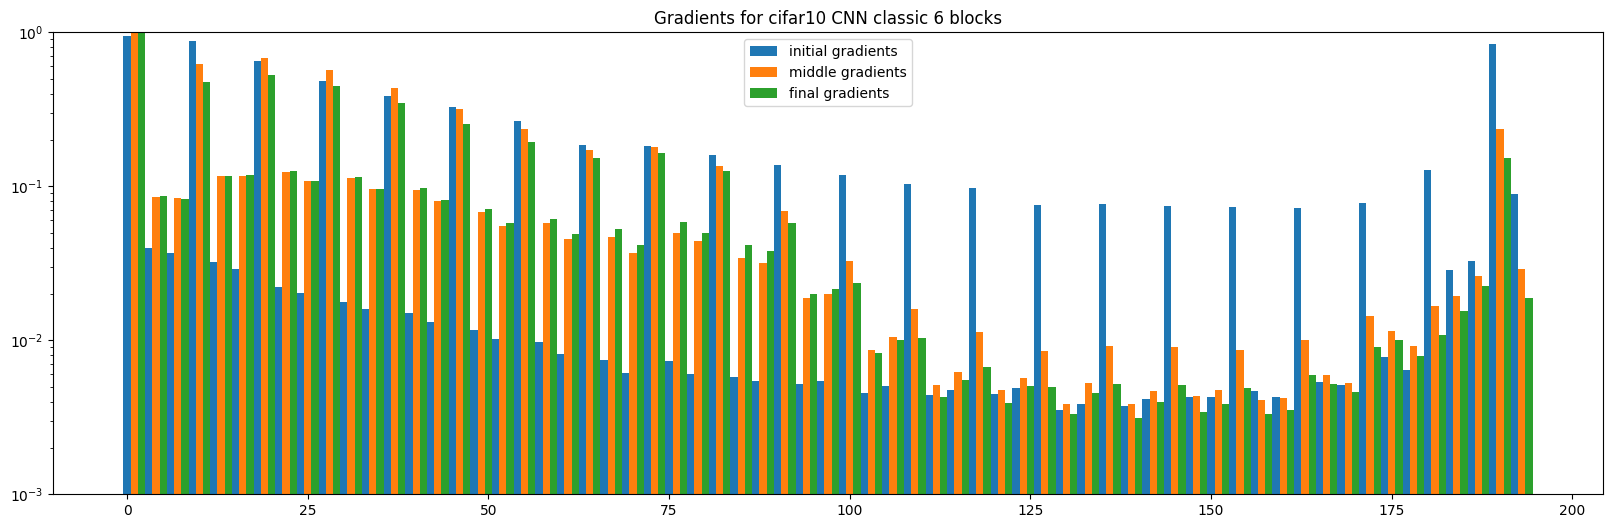

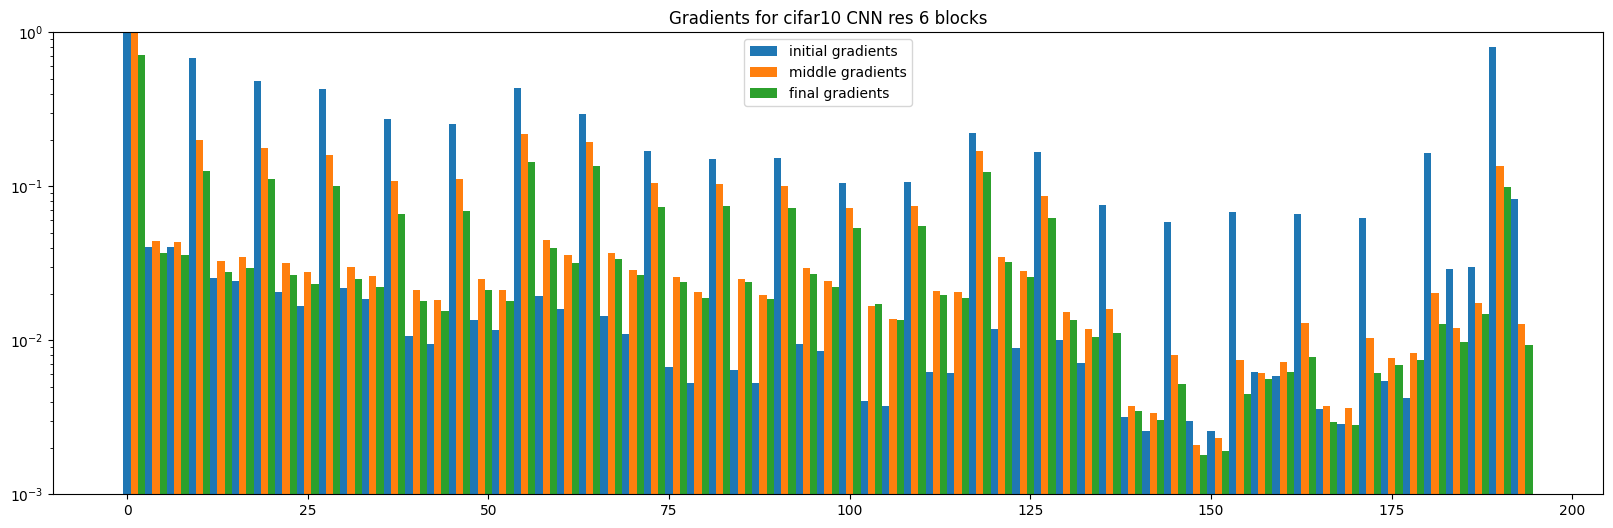

In [70]:
# Medium models
display_grads(6)

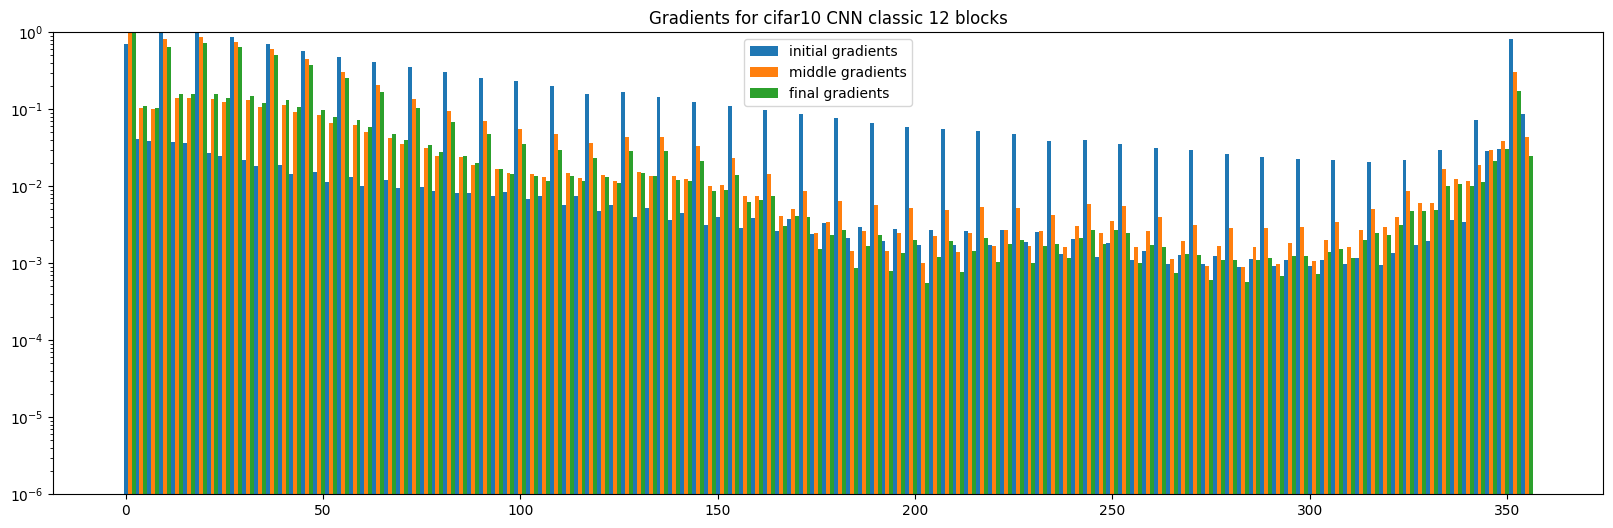

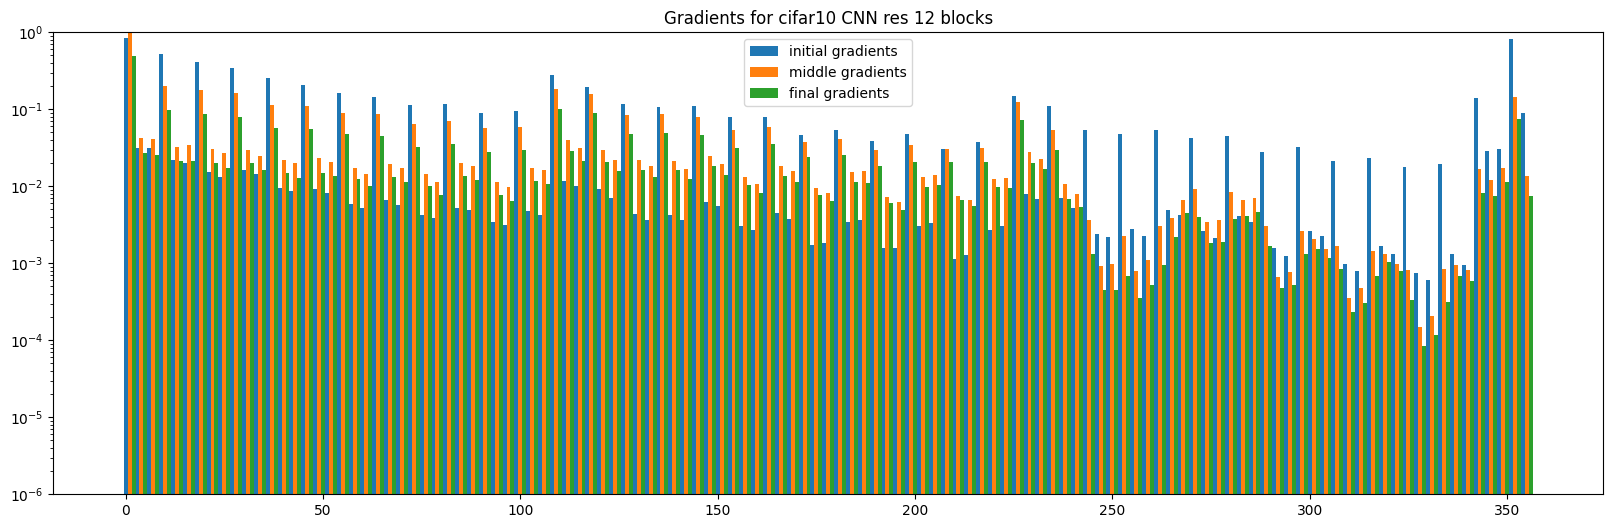

In [71]:
# Large Models
display_grads(12)

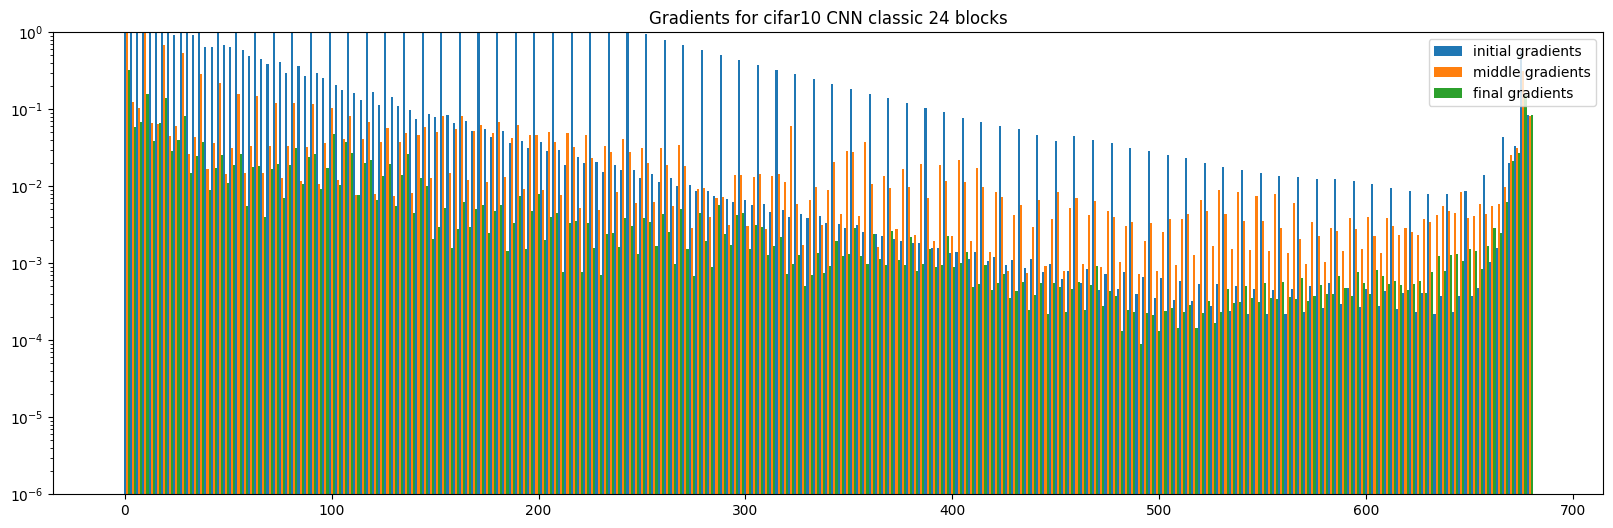

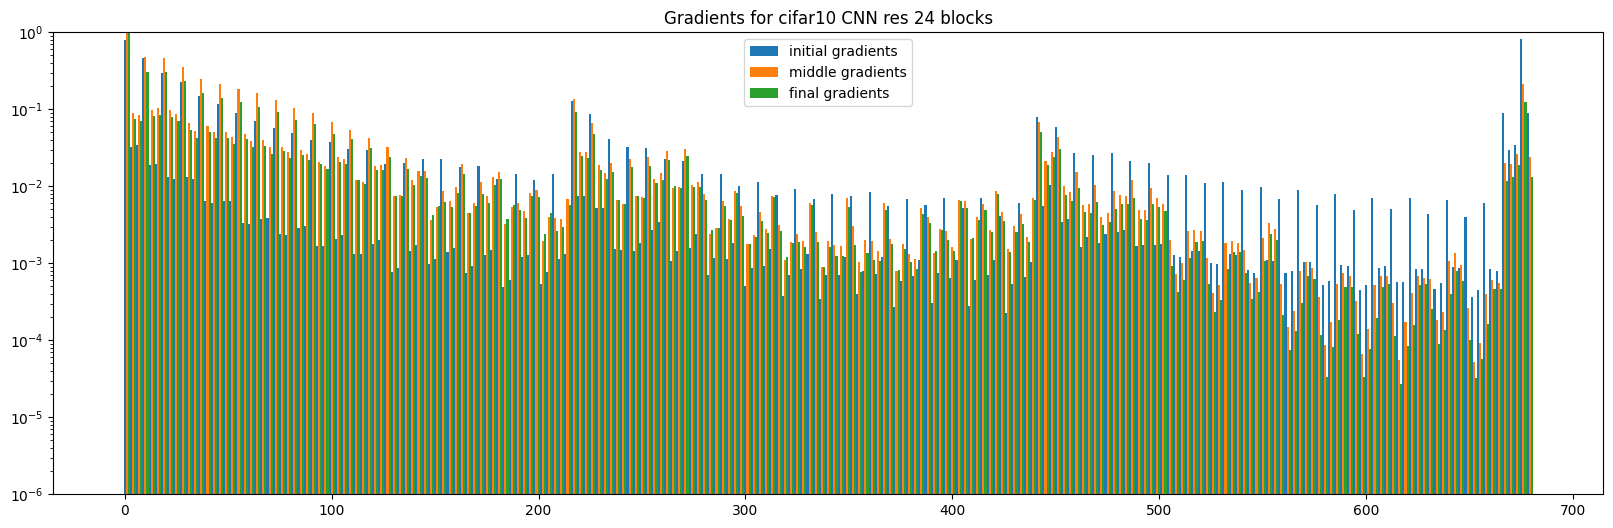

In [ ]:
# Huge Models
display_grads(24)

The plots above show that residul connections help to preserve the magnitude of the gradients during all of three phases of training (start, middle and final), moreover the effect is stronger with the growth of the models, this is not the only kind of hint we have about the performances, let's take a look on the loss functions during training

In [39]:
def display_loss(nb, dataset_str='cifar10'):
    base_path = f'./models/{dataset_str}'
    classic_str = f'CNN_classic_nb={nb}/loss.png'
    res_str = f'CNN_res_nb={nb}/loss.png'
    classic_path = f'{base_path}/{classic_str}'
    res_path = f'{base_path}/{res_str}'

    classic = display(Image(filename=classic_path))
    res = display(Image(filename=res_path))

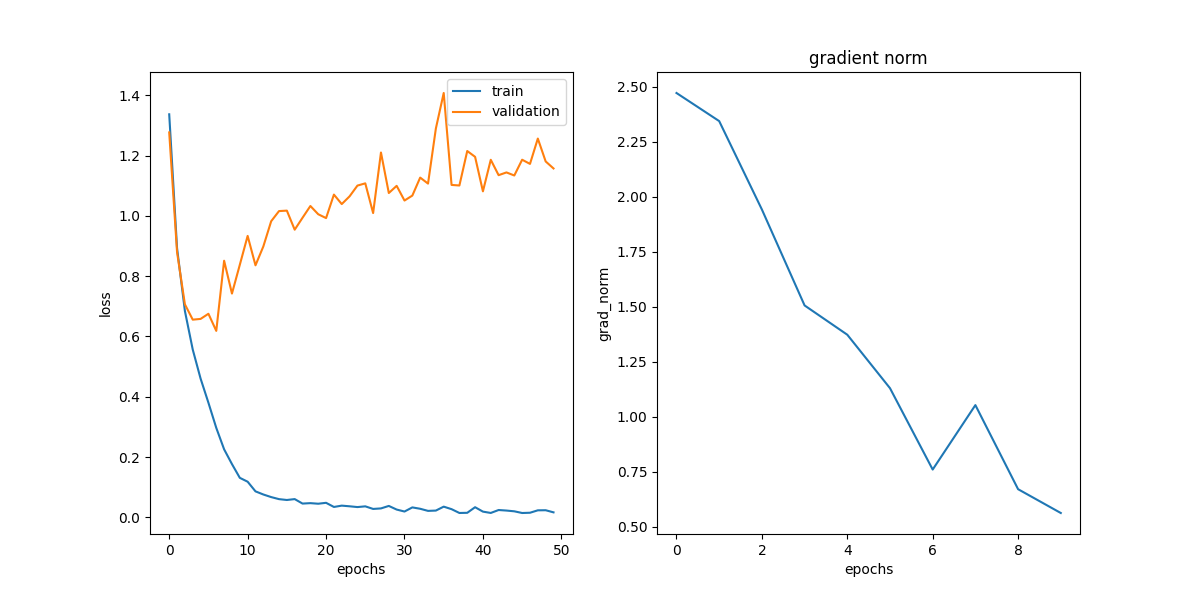

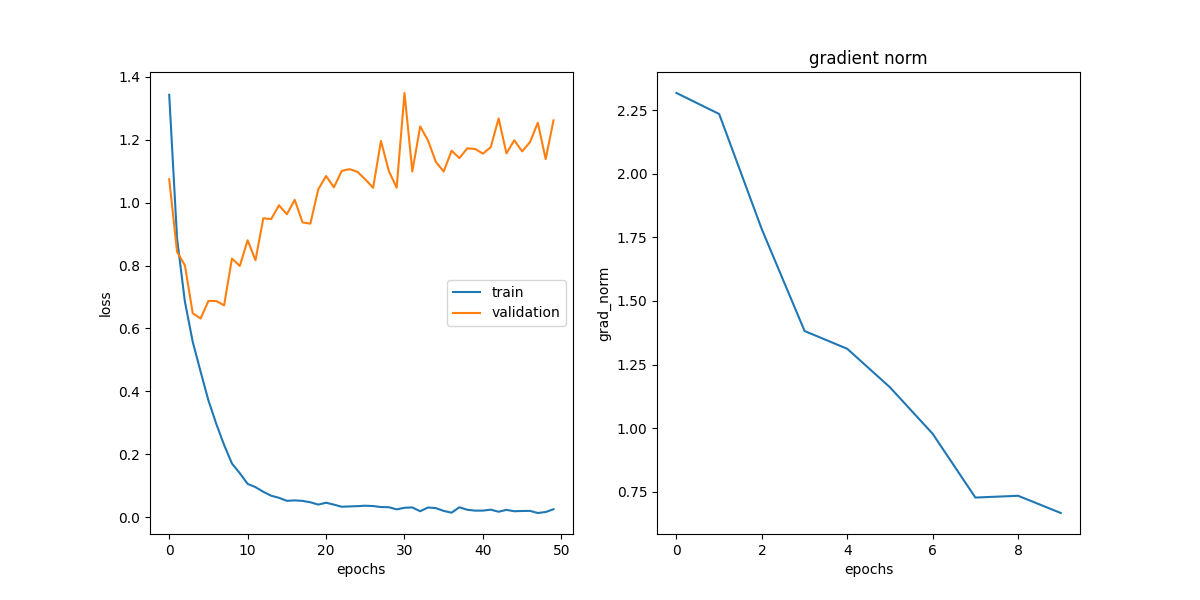

In [40]:
display_loss(2)

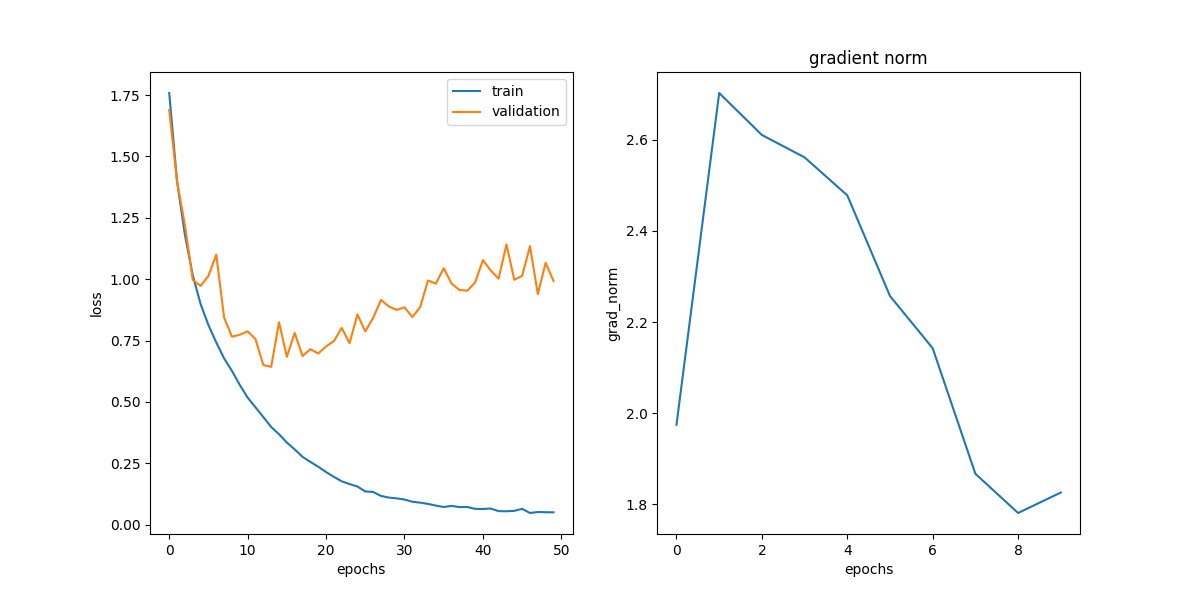

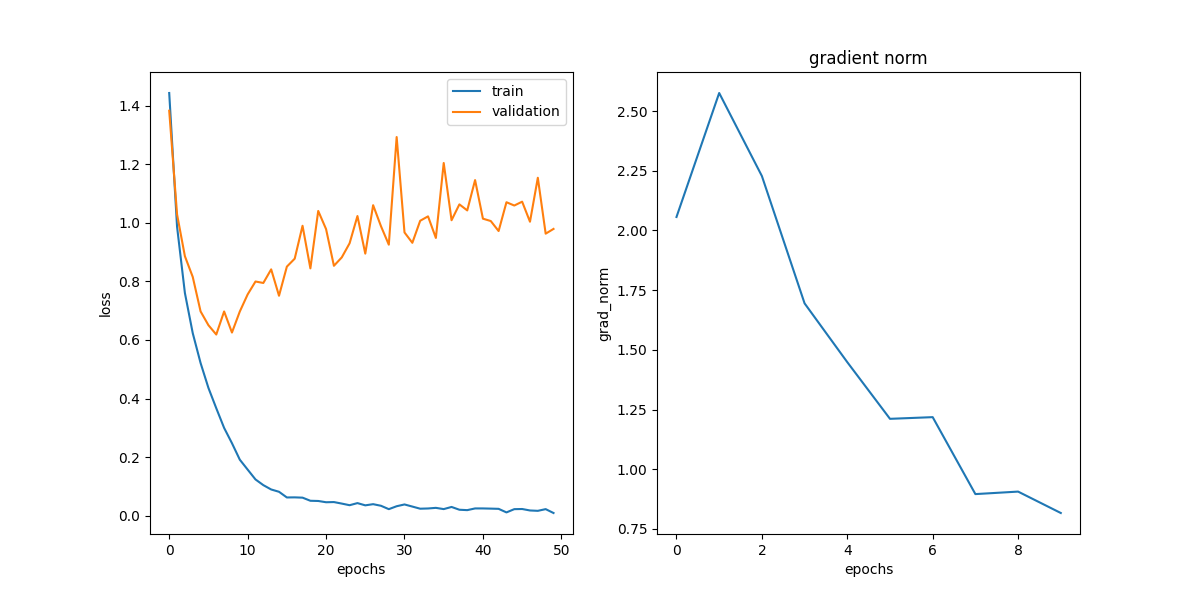

In [41]:
display_loss(6)

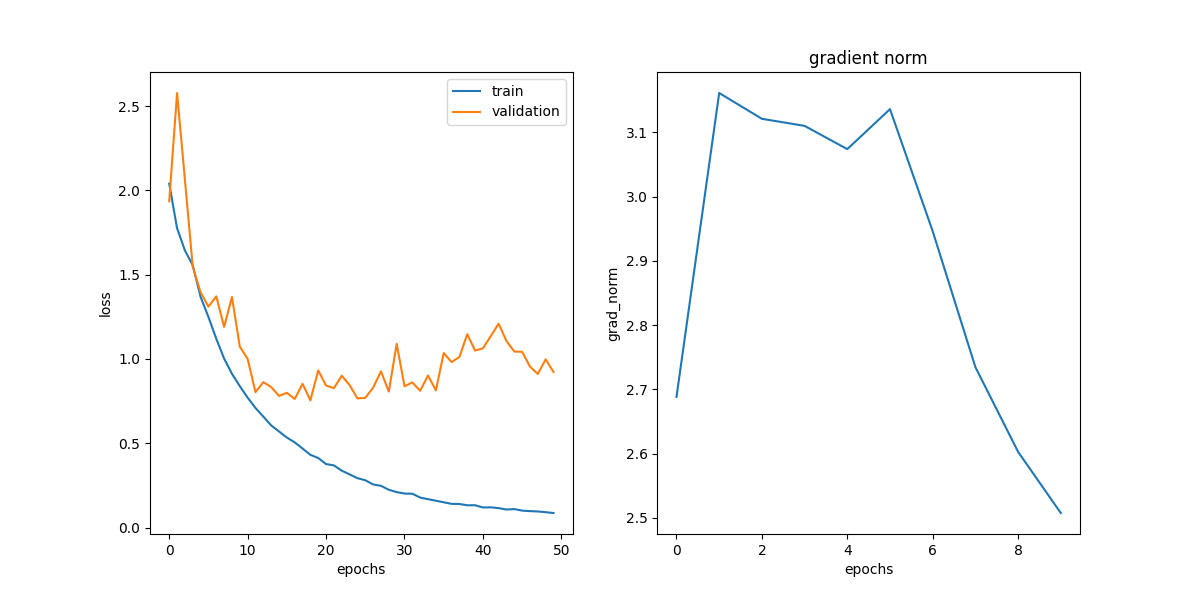

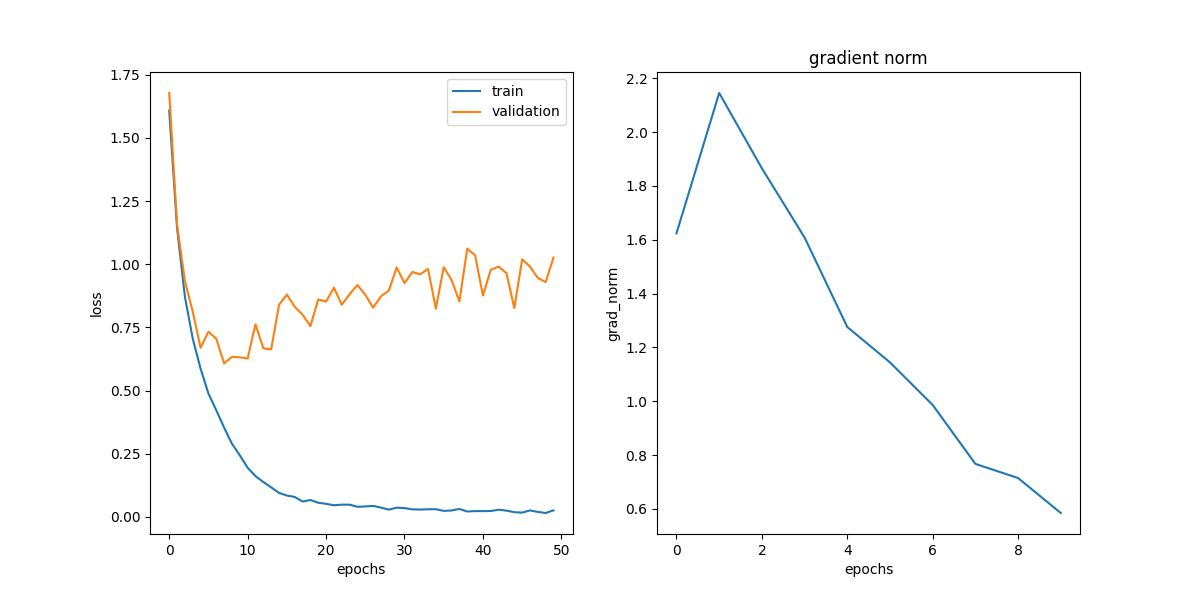

In [42]:
display_loss(12)

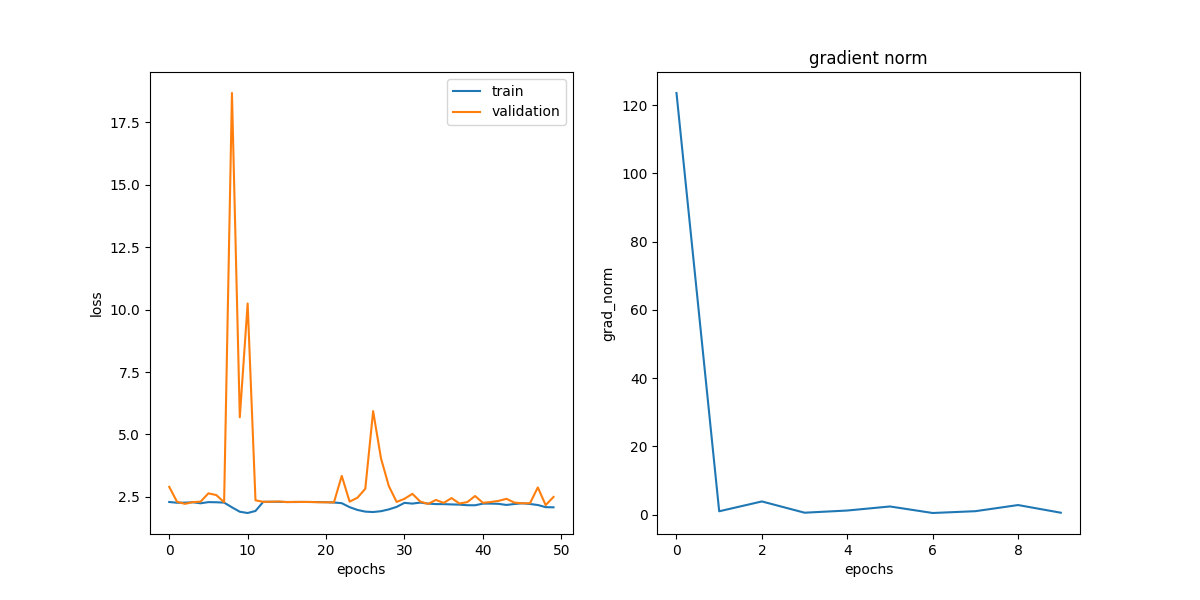

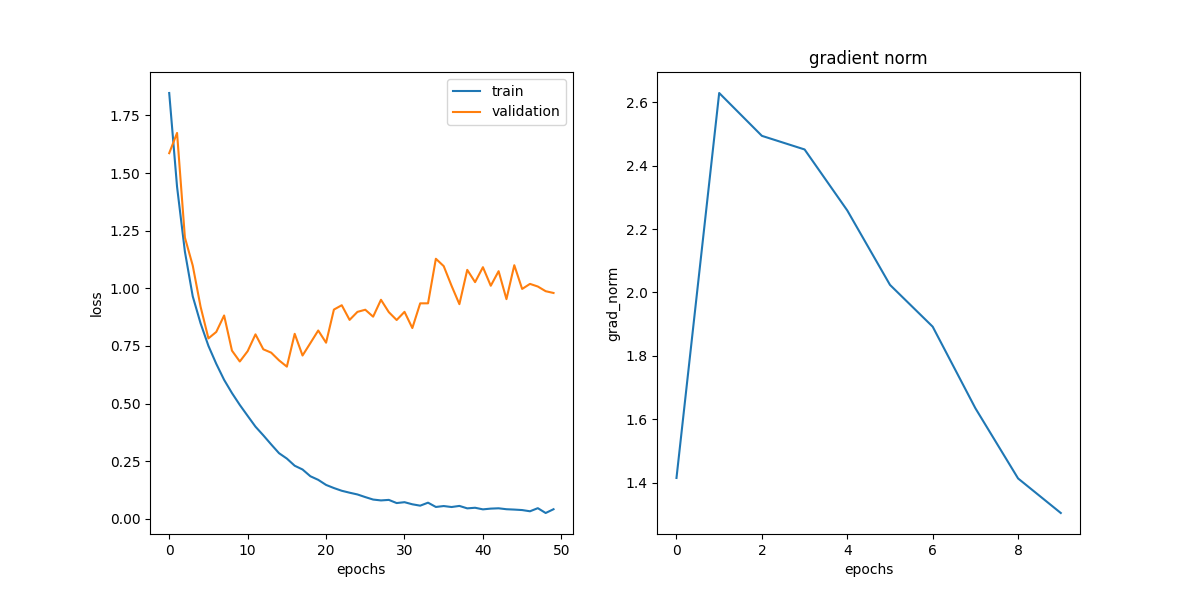

In [43]:
display_loss(24)

We can notice that there is a huge gain in the stability due to the use of residual connections, the norm of the gradient tend to 0, same for the loss, I want to add that even the 'level' of overfitting and the time (epochs) we need to reach it, is approximately the same.
Everything above is not valid for the vanilla counterpart we can see a training way more chaotic in every case, until we reach a point (huge model training) in which the model is not able to learn.

# Exercise 2.2

First to make the surgery useful, we have to embed more images into one, in this case i embedded 8 images in line (with a slight change it could be possible to implement different shape but the approach does not change)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].


[4, 2, 9, 3, 2, 1, 9, 8]


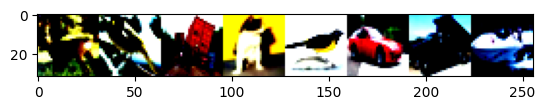

In [10]:
nimages = 8
emb_image = torch.zeros((in_channels, img_height, nimages*img_width))
for _, (x,y) in enumerate(dl_test):
    images = [x[i] for i in range(nimages)]
    digits = [y[i].item() for i in range(nimages)]
    break
for i in range(nimages):
    emb_image[:, :, i*img_width:(i+1)*img_width] = images[i]
plt.imshow(emb_image.permute(1, 2, 0) if in_channels == 3 else emb_image.squeeze())
print(digits)

For the surgery it is not necessary to train a new model, we load a previous model and change the head: we remove the Linear module and change the dimension of the AdaptiveAvgPool (the number of the embedded images is a parameter required by the model at this point), the weights of the Linear module will be the same as the convolution. 

In [28]:
class FullyConv(nn.Module):
    def __init__(self, block_ch, block_dim, classes, residual, nimages, model_path):
        super().__init__()
        self.name = "FullyConv"
        load_model = CNN(block_ch, block_dim, classes, residual).to(DEVICE)
        load_model.load_state_dict(torch.load(model_path + load_model.name + '/model_50.pth', weights_only=True))
        self.blocks = load_model.blocks
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, nimages)),
            nn.Conv2d(in_channels=block_ch[-1], out_channels=classes, kernel_size=1, stride=1, padding=0, bias=False)
        )
        self.head[1].weight.data = load_model.head[-1].weight.data.unsqueeze(2).unsqueeze(3)

    def forward(self, x):
        logits = self.blocks(x)
        return self.head(logits)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].


Ground Truth:	 [4 2 9 3 2 1 9 8]
Predictions:	 [7 2 9 3 0 1 9 8]
Accuracy: 0.7500


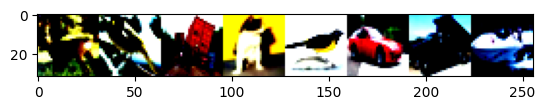

In [31]:
channels = [in_channels, 64, 128, 256]
block_dim = 12
residual = True

model_path = f'./models/{dataset_str}/'
model_fcnn = FullyConv(channels, block_dim, CLASSES, residual, nimages, model_path).to(DEVICE)
model_fcnn.eval()

with torch.no_grad():
    logits = model_fcnn(emb_image.unsqueeze(0).to(DEVICE))
    pred = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
    print(f'Ground Truth:\t {np.array(digits)}')
    print(f'Predictions:\t {pred}')
    print(f'Accuracy: {np.mean(pred == np.array(digits)):.4f}')
    plt.imshow(emb_image.permute(1, 2, 0) if in_channels == 3 else emb_image.squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].


Ground Truth:	 [4 2 9 3 2 1 9 8]
Predictions:	 [4 8 8 8 8 8 8 8]
Accuracy: 0.2500


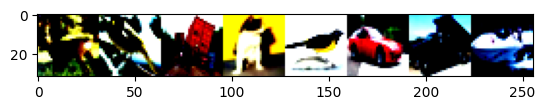

In [32]:
channels = [in_channels, 64, 128, 256]
block_dim = 12
residual = False

model_path = f'./models/{dataset_str}/'
model_fcnn = FullyConv(channels, block_dim, CLASSES, residual, nimages, model_path).to(DEVICE)
model_fcnn.eval()

with torch.no_grad():
    logits = model_fcnn(emb_image.unsqueeze(0).to(DEVICE))
    pred = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
    print(f'Ground Truth:\t {np.array(digits)}')
    print(f'Predictions:\t {pred}')
    print(f'Accuracy: {np.mean(pred == np.array(digits)):.4f}')
    plt.imshow(emb_image.permute(1, 2, 0) if in_channels == 3 else emb_image.squeeze())
    plt.show()

As expected the weights taken from a model without residual connections perform worse than the its counterpart.

# Exercise 2.3

In [44]:
channels = [in_channels, 64, 128, 256]
block_dim = 24
residual = True

model_cam = CNN(channels, block_dim, CLASSES, residual).to(DEVICE)
load_str = f'./models/{dataset_str}/{model_cam.name}/model_50.pth'
model_cam.load_state_dict(torch.load(load_str, weights_only=True))
model_cam.eval()

CNN(
  (blocks): Sequential(
    (0): ResBlock(
      (pool_layer): ConvLayer(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (conv_block): ConvBlock(
        (block): ModuleList(
          (0-23): 24 x ConvLayer(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
          )
        )
      )
    )
    (1): ResBlock(
      (pool_layer): ConvLayer(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (conv_block): ConvBlock(
        (block): ModuleList(
          (0-23): 24 x

In a similar way to the surgery, we have to work with the last layer of a pretrained model, this time we have to use the features of the last Convolutional Layer, use the weight of the classification head and project the first onto the latter, this way for each class we get the portion of image the model is looking to make the prediction of a given class

In [45]:
def get_img(data):
    data_img = data-data.min()
    data_img = data_img/data_img.max()
    data_img = np.uint8(data_img*255)
    data_img = cv2.cvtColor(data_img, cv2.COLOR_BGR2RGB)
    return data_img

def get_cam(model, data, class_idx):
    with torch.no_grad():
        last_conv_layer = torch.nn.Sequential(*list(model.blocks))
        conv_out = last_conv_layer(data.unsqueeze(0)).squeeze()
        C, H, W = conv_out.shape
        fc_weights = model.head[-1].weight
        cam = torch.matmul(fc_weights[class_idx], conv_out.reshape((C, H*W)))
        cam = cam.reshape((H, W))
        cam = cam - cam.min()
        cam_img = cam / cam.max()
        cam_img = np.uint8(255 * cam_img.cpu().numpy())
        return cam_img
    

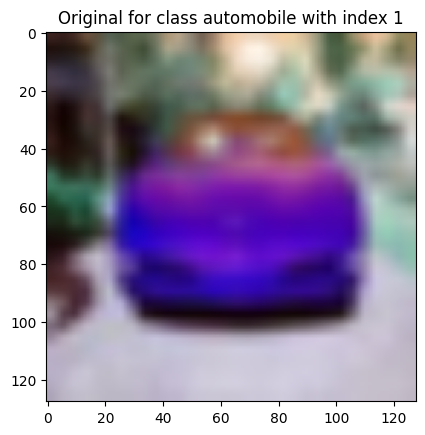

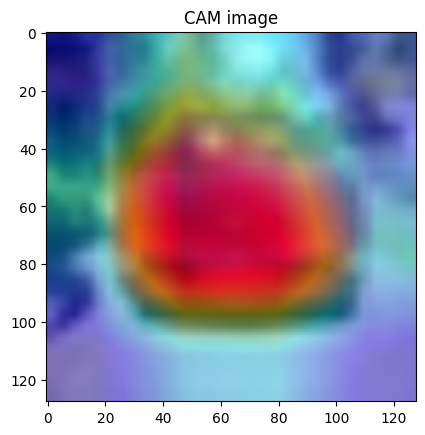

In [46]:
UP_DIM = (32*4, 32*4)

for data, target in dl_train:
    data, target = data[0].to(DEVICE), target[0].to(DEVICE)
    break

cam_img = get_cam(model_cam, data, target)
cam_img = cv2.resize(cam_img, UP_DIM)
heatmap = cv2.applyColorMap(cam_img, cv2.COLORMAP_JET)

data = data.cpu().numpy()
data = data.transpose(1, 2, 0)
data = cv2.resize(data, UP_DIM)
data_img = get_img(data)
plt.imshow(data_img)
plt.title(f'Original for class {ds_train.dataset.classes[target.item()]} with index {target.item()}')
plt.show()

cam_res = 0.5 * data_img + 0.3 * heatmap
cam_res = get_img(cam_res)
plt.imshow(cam_res)
plt.title(f'CAM image')
plt.show()